In [2]:
# 2022.04.07

### 1) import modules

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # 모듈 내 활성화함수, 손실함수, 함수적 코딩을 위한 신경망 함수 등 존재
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

### 2) define model architecture

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)  # in-channel, out-channel, kernel-size, strid
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)  # 4608 =  12 x 12 x 32
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 2nd arg: kernel size
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op
        

### define training and inference routines

model.train()과 model.eval()을 각각 train, test(validation) 전에 선언해주는 이유는, 학습시와 추론시에 다르게 동작해야 하는 레이어가 적절히 작동하도록 하기 위함이다. 대표적으로 'Dropout', 'Batchnormalization' 레이어는 학습, 추론시에 다르게 동작한다

In [30]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        # gradients를 backward 할 때 이전값에 더해지도록 기본 세팅되어있기 때문에
        # 0으로 초기화 (RNN과 같은 경우에선 안해주면 됨)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y)  # nll -> negative likelihood loss
        loss.backward()
        optim.step()

        # b_i*len(X): 누적 학습데이터포인트 수
        # len(train_dataloader.datasets): 전체 데이터 포인트 수
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()
            ))

In [31]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # 모든 배치에서 발생한 loss 누적시킴
            pred = pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()  # view_as: 인자와 같은 size(shape)로 반환 
    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader),
        100. * success / len(test_dataloader.dataset)
    ))        

#### 추가) tensor.armax()에서 keepdim의 역할

In [32]:
x = torch.tensor([[1,2,3],
                  [4,5,6],
                  [4,6,3]])

# 차원이 유지 or x
x.argmax(dim=1), x.argmax(dim=1, keepdims=True)

(tensor([2, 2, 1]),
 tensor([[2],
         [2],
         [1]]))

### create data loaders

In [33]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
# Normalize의 인자는 mean, std로 각 채널에 대한 값을 튜플로 전달함
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))])),
                    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))])),
                    batch_size=500, shuffle=False)

### define optimizer and run training epoch

In [34]:
torch.manual_seed(0)
device = torch.device('cpu')

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

### model training

In [35]:
for epoch in range(1,3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.316396
epoch: 1 [320/60000 (1%)]	 training loss: 2.074213
epoch: 1 [640/60000 (1%)]	 training loss: 1.602850
epoch: 1 [960/60000 (2%)]	 training loss: 0.883082
epoch: 1 [1280/60000 (2%)]	 training loss: 0.920290
epoch: 1 [1600/60000 (3%)]	 training loss: 0.686777
epoch: 1 [1920/60000 (3%)]	 training loss: 0.766417
epoch: 1 [2240/60000 (4%)]	 training loss: 0.339704
epoch: 1 [2560/60000 (4%)]	 training loss: 0.437659
epoch: 1 [2880/60000 (5%)]	 training loss: 0.333681
epoch: 1 [3200/60000 (5%)]	 training loss: 0.402200
epoch: 1 [3520/60000 (6%)]	 training loss: 0.262630
epoch: 1 [3840/60000 (6%)]	 training loss: 0.374559
epoch: 1 [4160/60000 (7%)]	 training loss: 0.135826
epoch: 1 [4480/60000 (7%)]	 training loss: 0.189522
epoch: 1 [4800/60000 (8%)]	 training loss: 0.215404
epoch: 1 [5120/60000 (9%)]	 training loss: 0.173413
epoch: 1 [5440/60000 (9%)]	 training loss: 0.232471
epoch: 1 [5760/60000 (10%)]	 training loss: 0.129612
epoch: 1 [6080/60

### run inference on trained model

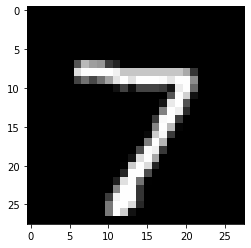

In [84]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

sample_data
plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')  # 배치의 첫번째 데이터
plt.show()

In [85]:
sample_data.size(), sample_data[0].size(), sample_data[0][0].size()

(torch.Size([500, 1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([28, 28]))

In [86]:
# 모델에 테스트 데이터를 입력한 출력: 배치의 데이터포인트 수 x 클래스별 확률
print(model(sample_data).data.size())
model(sample_data).data[:5]

torch.Size([500, 10])


tensor([[-2.1140e+01, -2.2123e+01, -1.7181e+01, -1.5219e+01, -2.1893e+01,
         -2.3477e+01, -2.8700e+01, -3.5763e-07, -2.1654e+01, -1.6887e+01],
        [-1.6975e+01, -1.2004e+01, -6.1989e-06, -1.8365e+01, -2.2363e+01,
         -2.5181e+01, -1.6664e+01, -2.2825e+01, -1.9987e+01, -2.6786e+01],
        [-1.6359e+01, -3.0398e-05, -1.1947e+01, -1.6026e+01, -1.1100e+01,
         -1.4184e+01, -1.4796e+01, -1.2334e+01, -1.2820e+01, -1.4475e+01],
        [-2.2053e-05, -1.5600e+01, -1.1197e+01, -1.7885e+01, -1.5496e+01,
         -1.7198e+01, -1.2067e+01, -1.5905e+01, -1.4320e+01, -1.3423e+01],
        [-2.0746e+01, -1.9006e+01, -1.9481e+01, -2.4923e+01, -1.6808e-05,
         -2.0860e+01, -2.1599e+01, -1.7445e+01, -1.7957e+01, -1.0992e+01]])

In [87]:
# numpy에서 max와 argmax를 동시에 수행해준다고 보면 될듯
model(sample_data).data.max(1)

torch.return_types.max(
values=tensor([-3.5763e-07, -6.1989e-06, -3.0398e-05, -2.2053e-05, -1.6808e-05,
        -2.0861e-05, -4.8636e-05, -7.5407e-04, -1.0305e-02, -4.4467e-04,
        -3.6955e-06, -2.0266e-06, -1.1670e-04, -8.3446e-07, -5.3644e-06,
        -5.2808e-05, -2.9802e-05, -2.1458e-06, -1.1653e-02, -2.3842e-07,
        -1.0734e-03, -1.5329e-04, -4.1723e-06, -4.7684e-07, -7.2357e-05,
        -4.2438e-05, -1.8954e-05, -2.3842e-07, -5.2212e-05, -2.8133e-05,
        -1.5259e-05, -4.0809e-04, -3.5763e-07, -4.1190e-04, -3.3379e-06,
        -9.5367e-07, -2.5153e-05, -9.4175e-06, -2.8610e-06, -2.6583e-05,
        -8.6781e-05, -3.6477e-05, -9.5720e-05, -2.4244e-04, -1.7665e-04,
        -7.2717e-06, -1.3527e-03, -2.3842e-07, -4.3391e-05, -5.9605e-07,
        -1.1921e-06, -5.5788e-05, -3.5763e-07, -1.2063e-04, -4.7684e-07,
        -4.2915e-06, -1.1921e-07, -5.9245e-05, -5.2452e-06, -3.3470e-03,
        -3.5763e-06, -1.2713e-03, -1.3970e-01, -5.3552e-02, -1.9073e-06,
        -6.2375e-04,

In [88]:
model(sample_data).data.max(1)[1][0]  # 1로 라벨값에 접근하여 첫번째 값을 가져옴

tensor(7)

In [89]:
print(f'Model prediction is : {model(sample_data).data.max(1)[1][0]}')
print(f'Ground truth is : {sample_targets[0]}')

Model prediction is : 7
Ground truth is : 7


In [ ]:
## mmseg torchvision